# Sea breeze identification

### Description
This recipe demonstrates the identification of sea breeze objects from hourly [AUS2200](https://dx.doi.org/10.25914/w95d-q328) data. This code was developed in support of Brown et al. (submitted).

The identification method is split into three modules:
1. **Loading model data and pre-processing**
2. **Computing sea breeze diagnostics**
3. **Defining sea breeze objects**

Each of these steps will be outlined in this notebook. The diagnostics used in step two are the Sea Breeze Index (SBI, [Hallgren et al. 2023](https://doi.org/10.1175/WAF-D-22-0163.1)), the moisture frontogenesis parameter, F (based on the [MetPy implementation](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.frontogenesis.html)), and the fuzzy logic algorithm developed by [Coceal et al. 2018](https://doi.org/10.1002/asl.846). The SBI identifies coastline-relative circulations based on the 3d wind field. F identifies regions of frontal growth that will include sea breeze fronts. The fuzzy logic algorithm uses local changes in temperature, humidity and wind to diagnose the passage of the sea breeze front. Step 3 uses a series of filters to try and remove non-sea-breeze fronts and circulations.

**Note** that there is no tracking of objects through time within the sea breeze code, this is not currently supported


### Data and software environment
This notebook requires direct access to the `bs94` [NCI project](https://my.nci.org.au/mancini/project/bs94/join) for AUS2200 data. 

### References
Brown, A., Vincent, C. and Short, E. Identifying sea breezes from atmospheric model output (sea\_breeze v1.1) [submitted]

Coceal O, Bohnenstengel SI, Kotthaus S. Detection of sea-breeze events around London using a fuzzy-logic algorithm. Atmos Sci Lett. 2018; 19:e846. https://doi.org/10.1002/asl.846

Hallgren, C., Körnich, H., Ivanell, S., & Sahlée, E. (2023). A Single-Column Method to Identify Sea and Land Breezes in Mesoscale-Resolving NWP Models. Weather and Forecasting, 38(6), 1025-1039. https://doi.org/10.1175/WAF-D-22-0163.1

----

First load require Python functions

In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Set and load the paths for your sea_breeze installation

In [2]:
sys.path.append('/home/548/ab4502/working/') # ⚠️ change to where your sea_breeze is placed

Set up your output path for sea breeze object statistics

In [3]:
stats_output_path = "/scratch/ng72/ab4502/tmp/"  #⚠️ change to where you want the .csv output, somewhere in your own directories

Set up a dask distributed client

In [4]:
client = Client()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40477 instead
  warnings.warn(


Import the sea breeze functions

In [5]:
from sea_breeze import (
load_model_data,
sea_breeze_funcs,
sea_breeze_filters
)

## 1) Load model data
The first module of the sea breeze code is to load and pre-process some model data. Here we are loading data from AUS2200 (https://dx.doi.org/10.25914/w95d-q328)

We first set the spatial and temporal bounds. Here we consider a single sea breeze case for Perth, Western Australia

In [6]:
#Time bounds for a single case (using 8 hours of data)
t1 = "2016-01-06 05:00"
t2 = "2016-01-06 12:00"

#Lat lon and height bounds (Perth, Australia). Height bounds chosen approximately as the typical maximum extent of the PBL
lat_slice = slice(-36,-30)
lon_slice = slice(113,119)
hgt_slice = slice(0,4500)


We now load the AUS2200 land sea mask, which we can use to define the angle of the dominant coastline throught the domain ($\theta$). The coastline angle calculation can take a while for high-res data and is very memory intensive for large domains

$\theta$ is required for defining the onshore wind component, used in the SBI and in some optional filtering settings

In [7]:
#Load land sea mask
orog, lsm = load_model_data.load_aus2200_static(
    "mjo-elnino2016",
    lon_slice,
    lat_slice)

#Compute coastline angles
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    R=4,
    latlon_chunk_size=8,
    compute=True,
    smooth=False)

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

Let's have a look at the resulting coastline angles, and also get an idea of the Perth domain. $\theta$ is defined as the coastline orientation (angle from North), such that a north-south oriented coastline with ocean to the west is 180$\degree$

The `get_coatline_angle` function also returns the variance of coastline angles for each point, as a measure of uncertainty in $\theta$. You can see that the variance is large halfway between the south and west coast of the domain, where there is no obvious "onshore" direction

In [8]:
angle_ds

<xarray.Dataset> Size: 3MB
Dimensions:          (lat: 303, lon: 303)
Coordinates:
  * lat              (lat) float64 2kB -36.0 -35.98 -35.96 ... -30.04 -30.02
  * lon              (lon) float64 2kB 113.0 113.0 113.0 ... 118.9 119.0 119.0
Data variables:
    angle            (lat, lon) float32 367kB dask.array<chunksize=(303, 303), meta=np.ndarray>
    variance         (lat, lon) float32 367kB dask.array<chunksize=(303, 303), meta=np.ndarray>
    coast            (lat, lon) int64 734kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    min_coast_dist   (lat, lon) float32 367kB dask.array<chunksize=(303, 303), meta=np.ndarray>
    angle_interp     (lat, lon) float64 734kB 140.5 140.4 140.2 ... 138.4 138.5
    variance_interp  (lat, lon) float64 734kB 0.03482 0.03503 ... 0.08223
Attributes:
    description:        Dataset of coastline angles and variance
    acknowledgmements:  This method was developed with help from Ewan Short a...
    R_km:               4

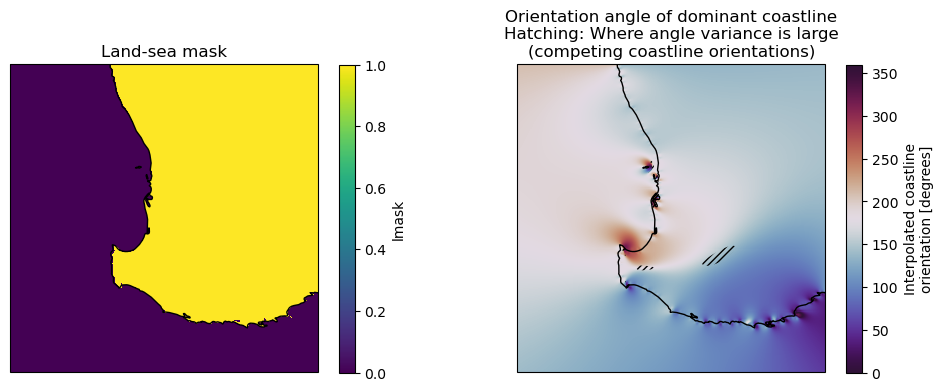

In [9]:
#Plot the model land sea mask and coastline angles
plt.figure(figsize=[12,4])
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
lsm.plot()
ax.coastlines()
plt.title("Land-sea mask")
ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
angle_ds.angle_interp.plot(cmap="twilight_shifted",vmin=0,vmax=360)
xr.plot.contourf(angle_ds.variance_interp,levels=[0.,0.5],hatches=["","/////"],colors="none",add_colorbar=False)
ax.coastlines()
plt.title("Orientation angle of dominant coastline\nHatching: Where angle variance is large\n(competing coastline orientations)");

---

Now let's load in the hourly AUS2200 data for computing the sea breeze diagnostics. We require the following variables for each diagnostic:

- Moisture frontogenesis (F)
    - Surface u and v winds (`uas`, `vas`)
    - Surface specific humidity (`hus`)
- Sea breeze index (SBI)
    - Model level u and v winds (`ua`, `va`)
    - Boundary layer depth (`zmla`)
    - Coastline orientation ($\theta$)
- Fuzzy logic algorithm
    - Surface u and v winds (`uas`, `vas`)
    - Surface specific humidity (`hus`)
    - Surface temperature (`tas`)
    - Coastline orientation ($\theta$)

We also have the option to smooth the fields within `load_aus2200_variable()`, through a Gaussian filter approach. We set this to `True` and set a $\sigma$ value of 4, which controls the amount of smoothing. This is because high resolution data can be very noisy, so some amount of smoothing can be beneficial for detecting sea breeze objects in certian situations.

Normally, we also would interpolate the `ua` and `va` variables to regular height intervals, but this is currently not supported in the sea breeze code due to some [missing metadata](https://forum.access-hive.org.au/t/aus2200-hybrid-height-coordinate/4538). The data here will remain on hybrid-height levels. This is good enough to demonstrate the SBI, but strictly speaking this should be done on height levels

In [10]:
#Set chunks for loading data
#Note because of our strategy applying xr.DataArray.map_blocks for smoothing, we need to 
# have time chunks of size 1.
chunks = {"lev":{},"time":1,"lat":-1,"lon":-1}

#Set smoothing option to True (gaussian smoothing filter with a sigma of 4. See scipy.ndimage.gaussian_filter)
smooth = True
sigma = 4

#For SBI
#Load V wind
aus2200_va = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "va",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lat",
        smooth=smooth,
        sigma=sigma,
        hgt_slice=hgt_slice,
        interp_hgts=False),
          "1hr")

#Load U wind
aus2200_ua = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "ua",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lon",
        smooth=smooth,
        sigma=sigma,
        hgt_slice=hgt_slice,
        interp_hgts=False),
          "1hr")

#Load boundary layer depth
aus2200_zmla = load_model_data.round_times(
        load_model_data.load_aus2200_variable(
            "zmla",
            t1,
            t2,
            "mjo-elnino2016",
            lon_slice,
            lat_slice,
            "1hr",
            chunks=chunks,
            staggered="time",
            smooth=smooth,
        sigma=sigma),
              "1hr")

#For frontogenesis
#Note that when we load in these surface variables, we will trigger the computations with persist(), to avoid
# chunking conflicts later when we compute some time rates of change

#Load surface V wind
aus2200_vas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lat",
        smooth=smooth,
        sigma=sigma),
          "10min").persist()

#Load surface U wind
aus2200_uas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lon",
        smooth=smooth,
        sigma=sigma),
          "10min").persist()

#Load surface specific humidity
aus2200_hus = load_model_data.load_aus2200_variable(
        "hus",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        smooth=smooth,
        sigma=sigma,
        hgt_slice=slice(0,10)).sel(lev=5).persist()

#Restrict everything to hourly (consistent with ua and va)
aus2200_vas = aus2200_vas.sel(time=aus2200_vas.time.dt.minute==0)
aus2200_uas = aus2200_uas.sel(time=aus2200_uas.time.dt.minute==0)    


#For fuzzy logic algorithm

#Load surface air temperature
aus2200_tas = load_model_data.load_aus2200_variable(
        "ta",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        smooth=smooth,
        sigma=sigma,
        hgt_slice=slice(0,10)).sel(lev=5).persist()

## 2) Compute sea breeze diagnostics

It is now very easy to compute the two sea breeze diagnostics we are interested in as part of the second module. Note this is done lazily with xarray/dask

In [11]:
#Sea breeze index
aus2200_wind = xr.Dataset({"u":aus2200_ua,"v":aus2200_va})
sbi = sea_breeze_funcs.calc_sbi(aus2200_wind,
                            angle_ds.angle_interp,
                            subtract_mean=False,
                            height_method="blh",
                            blh_da=aus2200_zmla,
                            vert_coord="lev")

In [12]:
#Moisture frontogenesis
F = sea_breeze_funcs.kinematic_frontogenesis(
        aus2200_hus,
        aus2200_uas,
        aus2200_vas
    ) 

In [13]:
#Fuzzy logic algorithm

#Compute the hourly rate of change in temperature, wind, and moisture. 
hourly_change = sea_breeze_funcs.hourly_change(
    aus2200_hus,
    aus2200_tas,
    aus2200_uas,
    aus2200_vas,
    angle_ds.angle_interp
)

#Combine into "fuzzy function"
F_fuzzy = field = sea_breeze_funcs.fuzzy_function_combine(
    hourly_change.wind_change,
    hourly_change.q_change,
    hourly_change.t_change, combine_method="mean")

Let's look at the output: 

In [14]:
sbi.sbi

<xarray.DataArray 'sbi' (lat: 303, lon: 303, time: 8)> Size: 6MB
dask.array<_nanmax_skip-aggregate, shape=(303, 303, 8), dtype=float64, chunksize=(303, 303, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -36.0 -35.98 -35.96 ... -30.06 -30.04 -30.02
  * lon      (lon) float64 2kB 113.0 113.0 113.0 113.1 ... 118.9 119.0 119.0
  * time     (time) datetime64[ns] 64B 2016-01-06T05:00:00 ... 2016-01-06T12:...
Attributes:
    units:        [0,1]
    long_name:    Sea breeze index
    description:  This index identifies regions where there is an onshore flo...

In [15]:
F.F

<xarray.DataArray 'F' (time: 8, lat: 303, lon: 303)> Size: 6MB
dask.array<mul, shape=(8, 303, 303), dtype=float64, chunksize=(1, 303, 303), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 64B 2016-01-06T05:00:00 ... 2016-01-06T12:...
    lev      float64 8B 5.0
  * lat      (lat) float64 2kB -36.0 -35.98 -35.96 ... -30.06 -30.04 -30.02
  * lon      (lon) float64 2kB 113.0 113.0 113.0 113.1 ... 118.9 119.0 119.0
Attributes:
    units:        g/kg/100km/3hr
    long_name:    Moisture frontogenesis
    description:  2d kinematic moisture frontogenesis parameter.

In [16]:
F_fuzzy

<xarray.DataArray (time: 7, lat: 303, lon: 303)> Size: 5MB
dask.array<truediv, shape=(7, 303, 303), dtype=float64, chunksize=(7, 303, 303), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -36.0 -35.98 -35.96 ... -30.06 -30.04 -30.02
  * lon      (lon) float64 2kB 113.0 113.0 113.0 113.1 ... 118.9 119.0 119.0
  * time     (time) datetime64[ns] 56B 2016-01-06T06:00:00 ... 2016-01-06T12:...
    lev      float64 8B 5.0
Attributes:
    combine_method:  mean
    units:           [0,1]
    long_name:       Fuzzy sea breeze detection algorithm
    description:     Fuzzy sea breeze detection algorithm using the rate of c...

Let's plot a few time steps of each of the diagnostics, along with the corresponding surface winds

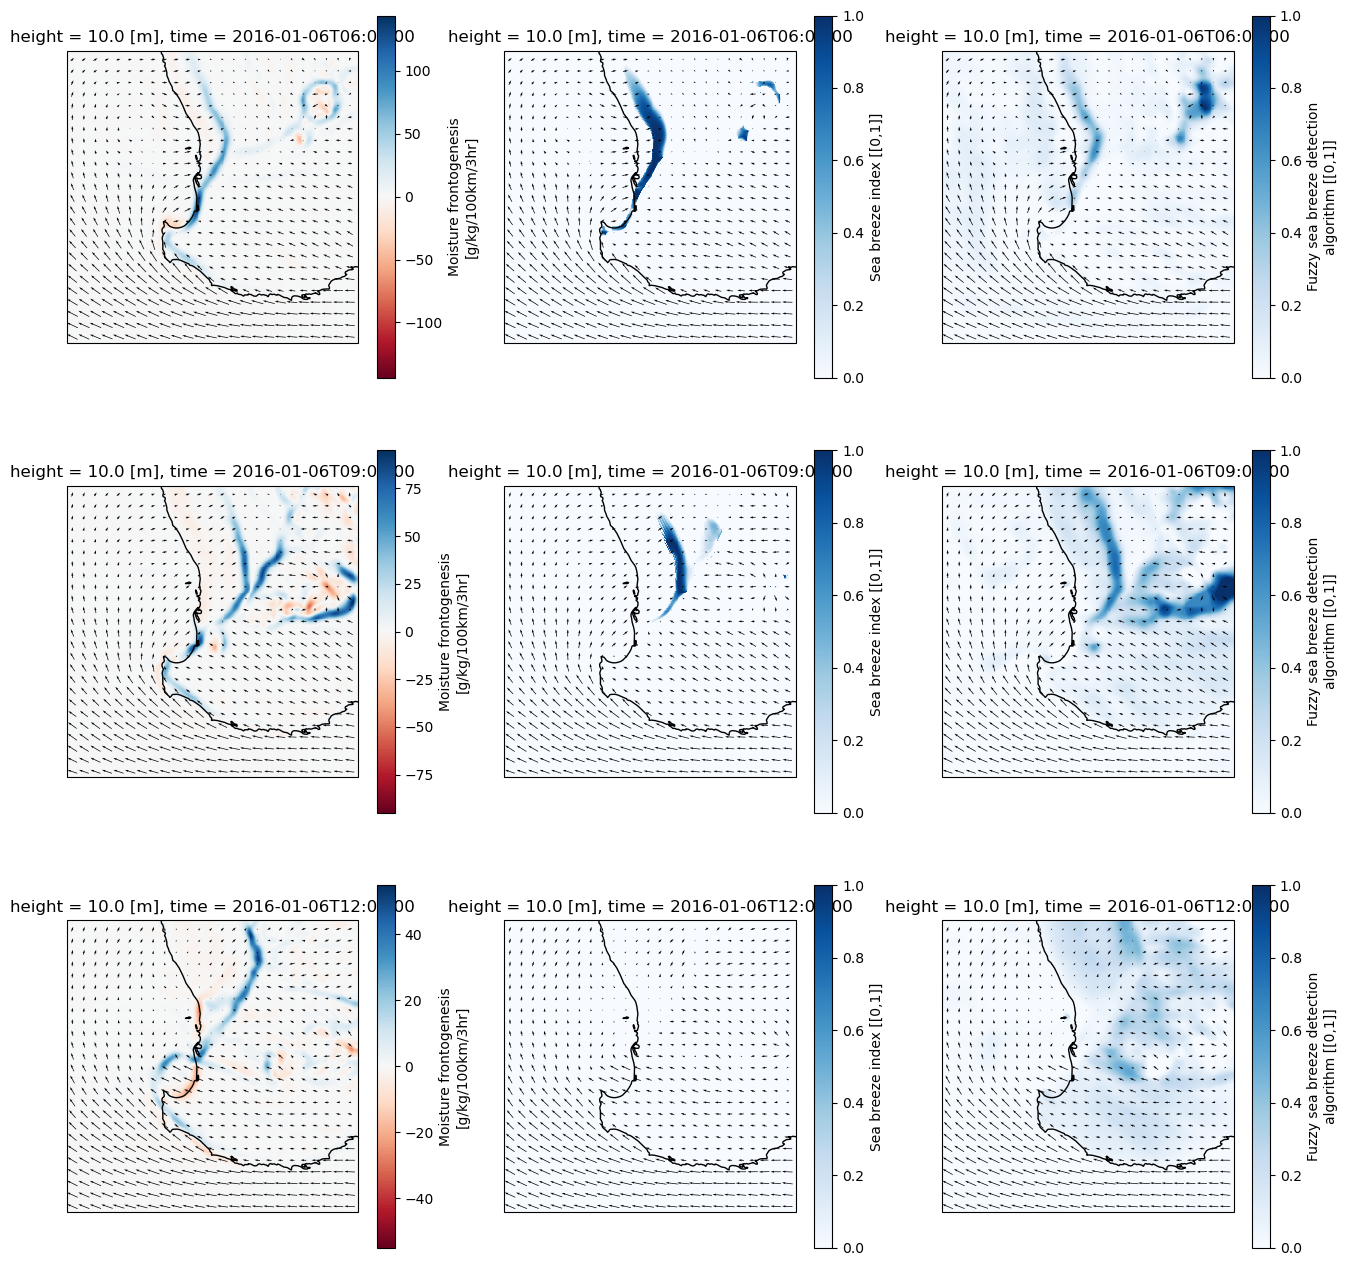

In [17]:
def plot(ds,field,ax,time,u,v,cmap,vmin=None,vmax=None):
    ds[field].sel(time=time).plot(cmap=cmap,vmin=vmin,vmax=vmax)
    xr.Dataset({"u":u,"v":v}).sel(time=t).coarsen({"lat":12,"lon":12},boundary="trim").mean().\
        plot.quiver(x="lon",y="lat",u="u",v="v")
    ax.coastlines()

plt.figure(figsize=[16,16])

t = "2016-01-06 06:00"
ax=plt.subplot(3,3,1,projection=ccrs.PlateCarree())
plot(F,"F",ax,t,aus2200_uas,aus2200_vas,cmap="RdBu")
ax=plt.subplot(3,3,2,projection=ccrs.PlateCarree())
plot(sbi,"sbi",ax,t,aus2200_uas,aus2200_vas,cmap="Blues",vmin=0,vmax=1)
ax=plt.subplot(3,3,3,projection=ccrs.PlateCarree())
plot(xr.Dataset({"fuzzy":F_fuzzy}),"fuzzy",ax,t,aus2200_uas,aus2200_vas,cmap="Blues",vmin=0,vmax=1)


t = "2016-01-06 09:00"
ax=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
plot(F,"F",ax,t,aus2200_uas,aus2200_vas,cmap="RdBu")
ax=plt.subplot(3,3,5,projection=ccrs.PlateCarree())
plot(sbi,"sbi",ax,t,aus2200_uas,aus2200_vas,cmap="Blues",vmin=0,vmax=1)
ax=plt.subplot(3,3,6,projection=ccrs.PlateCarree())
plot(xr.Dataset({"fuzzy":F_fuzzy}),"fuzzy",ax,t,aus2200_uas,aus2200_vas,cmap="Blues",vmin=0,vmax=1)


t = "2016-01-06 12:00"
ax=plt.subplot(3,3,7,projection=ccrs.PlateCarree())
plot(F,"F",ax,t,aus2200_uas,aus2200_vas,cmap="RdBu")
ax=plt.subplot(3,3,8,projection=ccrs.PlateCarree())
plot(sbi,"sbi",ax,t,aus2200_uas,aus2200_vas,cmap="Blues",vmin=0,vmax=1)
ax=plt.subplot(3,3,9,projection=ccrs.PlateCarree())
plot(xr.Dataset({"fuzzy":F_fuzzy}),"fuzzy",ax,t,aus2200_uas,aus2200_vas,cmap="Blues",vmin=0,vmax=1)

We can see that each of the diagnostics indicates a sea breeze that moves inland throughout the afternoon from the west coast of the domain. The frontogenesis diagnostic is a continuous value with positive values representing areas of frontal growth due to the horizontal flow, and negative areas representing frontal decay. The SBI ranges from 0 to 1, with higher values indicative of sea breeze circulations. The fuzzy logic algorithm also ranges from 0 to 1, with higher values indicative of sea breeze fronts.

The sea breeze circulation (as characterised by the SBI) tends to decay faster than the surface sea breeze front (characterised by F), as you can see at 12:00 UTC (20:00 local standard time)

Note that there are several regions of large diagnostic values that do not really look like sea breezes. This includes several inland areas well ahead of the sea breeze front with the F and fuzzy logic diagnostic, likely representing convecive cold pools. This is also seen to a lesser extent with the SBI.

This is where our filtering comes in (as well as the smoothing we did when loading the data, as this also reduces the impact of small-scale, non-sea-breeze processes)

----

## 3) Object detection and filtering

The third and final module is to use a threshold on each diagnostic, to define candidate sea breeze objects, and then use filtering to remove objects that probably aren't sea breezes.

For the thresholds, we will hard-code these as `0.41` for the SBI, `18.8` g/kg/100km/3hr
 for F, and `0.20` for the fuzzy logic algorithm. These are equivalent to the 99.5th percentile over 6 months of Jan-Feb AUS2200 data (see accompanying paper)

We have several options for filtering. These can be viewed under the Keyword section of the `filter_2d()` function documentation

In [18]:
sea_breeze_filters.filter_2d?

Signature:
sea_breeze_filters.filter_2d(
    ds,
    angle_ds=None,
    lsm=None,
    props_df_output_path=None,
    output_land_sea_temperature_diff=False,
    **kwargs,
)
Docstring:
Take a binary sea breeze mask and identify objects, then filter it for sea breezes based on several conditions related to those objects.

Works for a 2D "lat"/"lon" xarray dataset. Can be extended to work with a time dimension using map_blocks (see process_time_slice and filter_3d).

Parameters
----------
ds : xarray.Dataset
    Dataset with variable "mask", a 2D binary mask of sea breeze objects and attribute "time" (UTC). May also contain for additional filtering:
        - "ta" : surface temperature
        - "t_change" : temperature change
        - "q_change" : specific humidity change
        - "wind_change" : onshore wind speed change
        - "vprime" : onshore wind component
angle_ds : xarray.Dataset, optional
    Dataset of coastline angles and distance to coast for orientation and distance to 

--- 
The default filters can also be viewed as generated by the `Mask_Options` class

In [19]:
print(sea_breeze_filters.Mask_Options())

Filters: {'orientation_filter': False, 'aspect_filter': True, 'area_filter': True, 'time_filter': False, 'dist_to_coast_filter': False, 'land_sea_temperature_filter': False, 'temperature_change_filter': False, 'humidity_change_filter': False, 'wind_change_filter': False, 'onshore_wind_filter': False} 
 Thresholds: {'orientation_tol': 30, 'area_thresh_km': 50, 'area_thresh_pixels': 20, 'aspect_thresh': 3, 'hour_min_lst': 9, 'hour_max_lst': 22, 'land_sea_temperature_diff_thresh': 0, 'temperature_change_thresh': 0, 'humidity_change_thresh': 0, 'wind_change_thresh': 0, 'max_distance_to_coast_thresh': 300, 'min_distance_to_coast_thresh': 0, 'onshore_wind_thresh': 0}


-----

We will go ahead and perform the filtering with just a few simple options turned on

`.compute()` is applied to the output of `filter_3d` to trigger the computation. This will make sure all the object stats are computed/saved

In [20]:
#Set up filtering options. Here just use the orientation, aspect ratio and area filters
kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":False,                    
    "temperature_change_filter":False,
    "humidity_change_filter":False,
    "wind_change_filter":False,
    "onshore_wind_filter":False,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    }

#Set the fixed SBI and F thresholds. These represent the 99.5th percentile 
# from AUS2200 data over a 6-month period 
thresh_sbi = 0.41
thresh_F = 18.8
thresh_fuzzy = 0.20

#Do the filtering using filter_3d
F_objects = sea_breeze_filters.filter_3d(
    F.F,
    threshold="fixed",
    threshold_value=thresh_F,
    lsm=lsm,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path=stats_output_path + "sb_stats_F.csv",
    **kwargs).compute()

sbi_objects = sea_breeze_filters.filter_3d(
    sbi.sbi,
    threshold="fixed",
    threshold_value=thresh_sbi,
    lsm=lsm,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path=stats_output_path + "sb_stats_sbi.csv",
    **kwargs).compute()

fuzzy_objects = sea_breeze_filters.filter_3d(
    F_fuzzy,
    threshold="fixed",
    threshold_value=thresh_fuzzy,
    lsm=lsm,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path=stats_output_path + "sb_stats_fuzzy.csv",
    **kwargs).compute()


Print some of the object statistics that were saved as a .csv (eccentricity, area, orientation, major and minor axis length, centroid location, local solar time, aspect ratio)

In [21]:
pd.read_csv(stats_output_path + "sb_stats_F.csv").set_index("time_utc").sort_index().head()

,index,eccen,area,orient,major,minor,lon_centroid,lat_centroid,lst,aspect,area_km
time_utc,,,,,,,,,,,
2016-01-06 05:00:00,7,0.892932,31,-34.160705,9.318103,4.194938,115.439995,-30.156199,2016-01-06 12:41:45.598755,2.221273,129.921979
2016-01-06 05:00:00,1,0.980037,427,-46.024658,63.537859,12.632226,115.301399,-34.135998,2016-01-06 12:41:12.335815,5.029823,1713.219446
2016-01-06 05:00:00,2,0.976567,1574,7.571163,166.252724,35.779549,115.835999,-32.294598,2016-01-06 12:43:20.639648,4.646585,6448.423321
2016-01-06 06:00:00,2,0.972578,1838,7.461535,183.762606,42.739047,115.934998,-32.155998,2016-01-06 13:43:44.399414,4.299642,7541.105602
2016-01-06 06:00:00,3,0.914698,60,7.900962,14.014217,5.663681,117.994194,-31.819399,2016-01-06 13:51:58.606567,2.474401,247.122691


In [22]:
pd.read_csv(stats_output_path + "sb_stats_sbi.csv").set_index("time_utc").sort_index().head()

,index,eccen,area,orient,major,minor,lon_centroid,lat_centroid,lst,aspect,area_km
time_utc,,,,,,,,,,,
2016-01-06 05:00:00,2,0.971466,1215,6.672422,142.038957,33.688895,115.875595,-32.037201,2016-01-06 12:43:30.142822,4.216195,4992.421086
2016-01-06 06:00:00,2,0.956299,119,49.155597,27.970329,8.178284,115.439995,-33.561798,2016-01-06 13:41:45.598755,3.420073,480.672055
2016-01-06 06:00:00,3,0.959685,1590,-1.958824,132.433918,37.224170,115.974594,-31.720398,2016-01-06 13:43:53.902588,3.557740,6555.367342
2016-01-06 06:00:00,5,0.927911,151,-50.111261,31.132014,11.606100,118.449600,-30.750198,2016-01-06 13:53:47.904053,2.682384,629.027084
2016-01-06 07:00:00,1,0.958089,46,75.825822,20.715309,5.934326,115.123199,-33.739998,2016-01-06 14:40:29.567871,3.490761,185.435695


In [23]:
pd.read_csv(stats_output_path + "sb_stats_fuzzy.csv").set_index("time_utc").sort_index().head()

,index,eccen,area,orient,major,minor,lon_centroid,lat_centroid,lst,aspect,area_km
time_utc,,,,,,,,,,,
2016-01-06 06:00:00,1,0.963277,1738,-5.376058,148.577621,39.894742,115.915199,-31.621399,2016-01-06 13:43:39.647827,3.724241,7172.516034
2016-01-06 07:00:00,1,0.965374,2278,-2.551986,171.222921,44.667160,116.033997,-31.720398,2016-01-06 14:44:08.159180,3.833307,9391.631056
2016-01-06 08:00:00,2,0.974720,3156,-6.537301,191.680008,42.827248,116.132996,-31.522398,2016-01-06 15:44:31.918945,4.475655,13038.770015
2016-01-06 08:00:00,5,0.878055,125,-63.474206,18.648312,8.924333,117.974396,-31.423399,2016-01-06 15:51:53.854980,2.089603,517.044076
2016-01-06 10:00:00,8,0.870576,304,-30.993723,28.345824,13.947111,115.618195,-30.809599,2016-01-06 17:42:28.366699,2.032380,1265.690299


Plot the objects for the same time steps as above

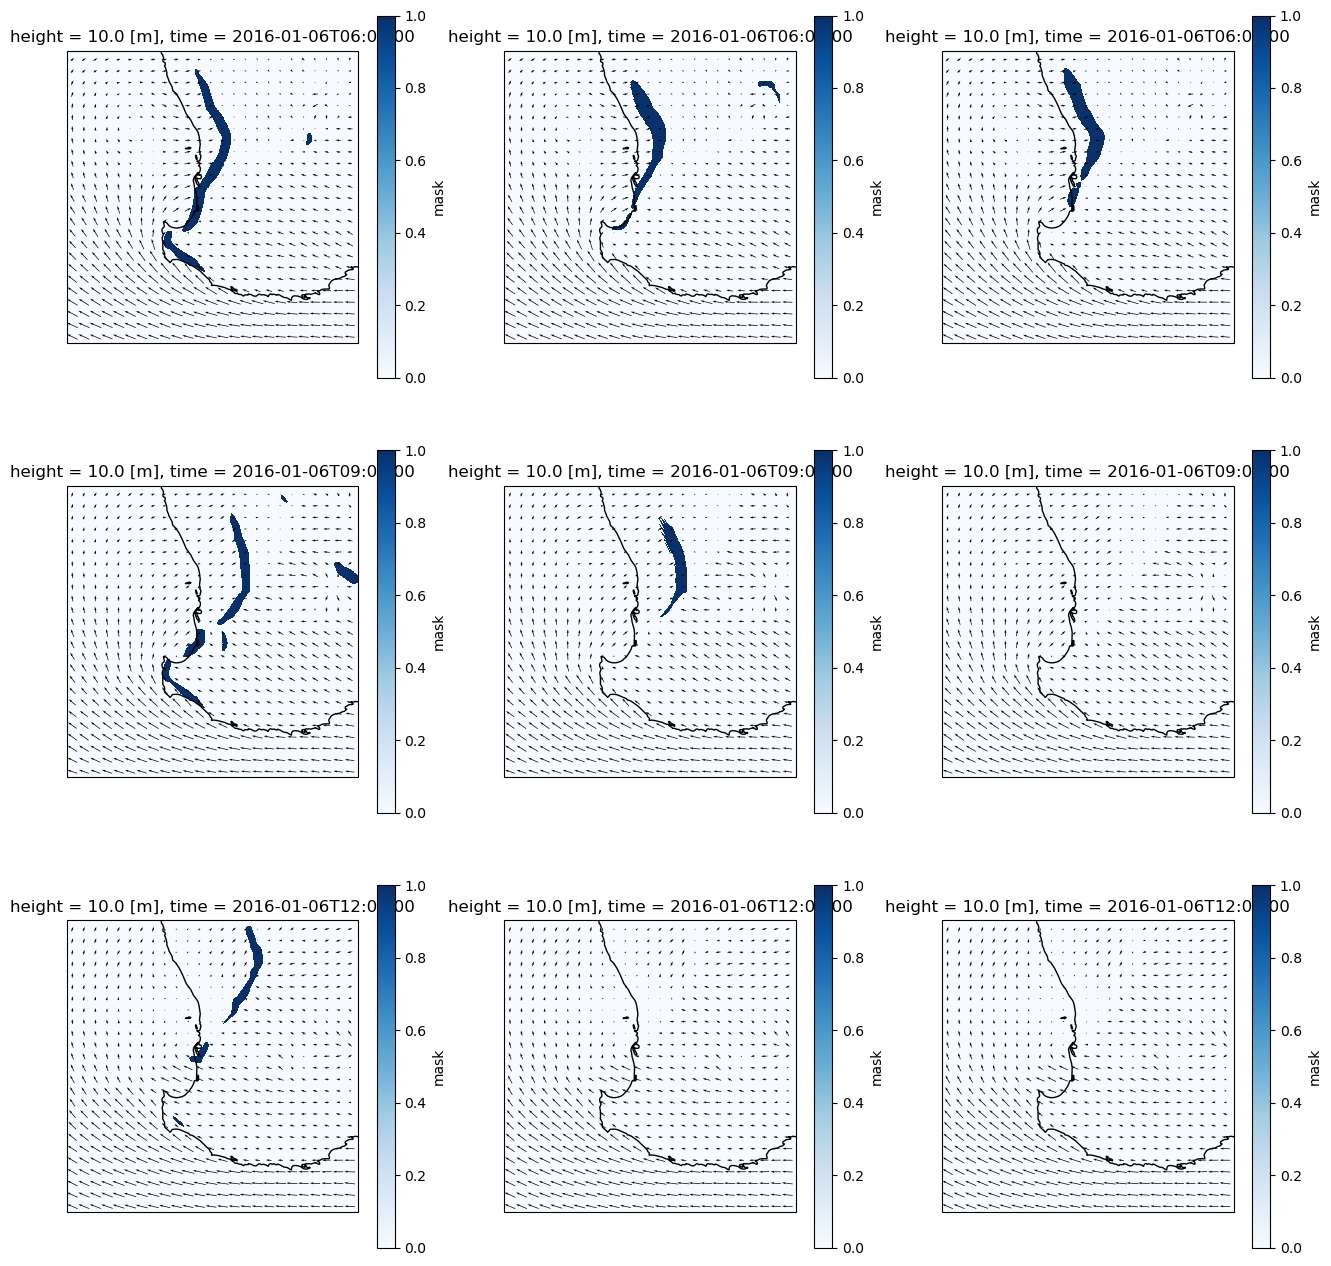

In [24]:
def plot(ds,field,ax,time,u,v,cmap):
    ds[field].sel(time=time).plot(cmap=cmap,vmin=0,vmax=1)
    xr.Dataset({"u":u,"v":v}).sel(time=t).coarsen({"lat":12,"lon":12},boundary="trim").mean().\
        plot.quiver(x="lon",y="lat",u="u",v="v")
    ax.coastlines()

plt.figure(figsize=[16,16])

t = "2016-01-06 06:00"
ax=plt.subplot(3,3,1,projection=ccrs.PlateCarree())
plot(F_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,2,projection=ccrs.PlateCarree())
plot(sbi_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,3,projection=ccrs.PlateCarree())
plot(fuzzy_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 09:00"
ax=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
plot(F_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,5,projection=ccrs.PlateCarree())
plot(sbi_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,6,projection=ccrs.PlateCarree())
plot(fuzzy_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 12:00"
ax=plt.subplot(3,3,7,projection=ccrs.PlateCarree())
plot(F_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,8,projection=ccrs.PlateCarree())
plot(sbi_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,9,projection=ccrs.PlateCarree())
plot(fuzzy_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")

You can see that the combination of thresholding the diagnostics and filtering the results generally restricts the objects to the sea breezes we are interested in. But this is not perfect (there are some un-filtered diagnostic values that remain)

## Other more complex filtering settings

Other more complex filtering settings are available, but these require more pre-processing. These are demonstrated below and includes:

* The `onshore_wind_filter`, which requires us to first calculate the onshore wind (vprime)
* The `temperature_change_filter`, `humidity_change_filter` and `wind_change_filter`, using the `hourly_change` dataset
* The `land_sea_temperature_filter`, using `aus2200_ta` and `lsm` datasets

Note that the `land_sea_temperature_filter` can add significant time for large computations. Also `hourly_change` has one less hour of data compared with the diagnostics, due to the calculation of the time rate of change by backward difference. This will impact filtering for the first time step. In practice, one extra hour should be loaded for calculating `hourly_change` relative to  the intended time window.

In [25]:
#Demonstrate other filtering settings

#Calculate the onshore wind component (vprime) for the onshore_wind_filter
uprime, vprime = sea_breeze_funcs.rotate_wind(
    aus2200_uas,
    aus2200_vas,
    angle_ds["angle_interp"])

#Set up new filtering options
kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":True,         #Now True                    
    "temperature_change_filter":True,           #Now True                    
    "humidity_change_filter":True,              #Now True                    
    "wind_change_filter":True,                  #Now True                    
    "onshore_wind_filter":True,            #Now True                    
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    }

#Do the updated filtering
F_objects_v2 = sea_breeze_filters.filter_3d(
    F.F,
    hourly_change_ds=hourly_change,
    ta=aus2200_tas,
    vprime=vprime,
    threshold="fixed",
    lsm=lsm,
    threshold_value=thresh_F,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path=stats_output_path + "sb_stats_F_v2.csv",
    **kwargs).compute()

sbi_objects_v2 = sea_breeze_filters.filter_3d(
    sbi.sbi,
    hourly_change_ds=hourly_change,
    ta=aus2200_tas,
    vprime=vprime,
    threshold="fixed",
    threshold_value=thresh_sbi,
    lsm=lsm,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path=stats_output_path + "sb_stats_sbi_v2.csv",
    **kwargs).compute()

fuzzy_objects_v2 = sea_breeze_filters.filter_3d(
    F_fuzzy,
    hourly_change_ds=hourly_change,
    ta=aus2200_tas,
    vprime=vprime,
    threshold="fixed",
    threshold_value=thresh_fuzzy,
    lsm=lsm,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path=stats_output_path + "sb_stats_fuzzy_v2.csv",
    **kwargs).compute()

/home/548/ab4502/working/sea_breeze/sea_breeze_filters.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props_df["time_utc"] = time
/home/548/ab4502/working/sea_breeze/sea_breeze_filters.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props_df["time_utc"] = time


Plot the objects with the updated set of filters

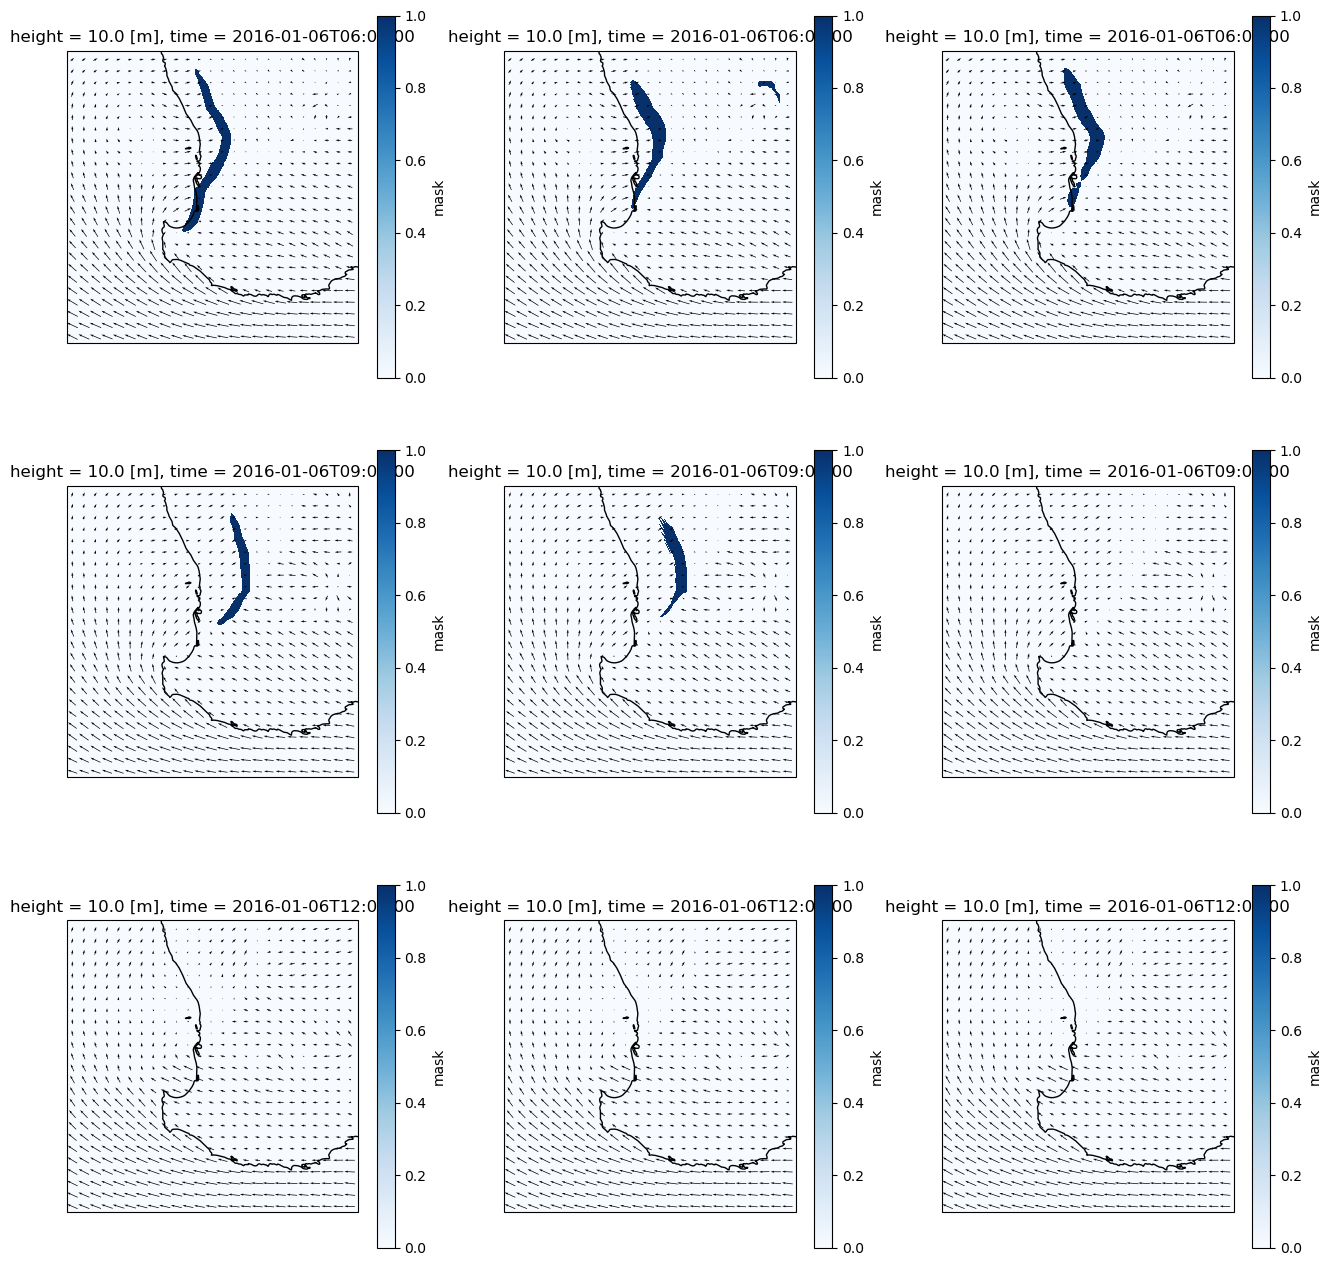

In [26]:
def plot(ds,field,ax,time,u,v,cmap):
    ds[field].sel(time=time).plot(cmap=cmap,vmin=0,vmax=1)
    xr.Dataset({"u":u,"v":v}).sel(time=t).coarsen({"lat":12,"lon":12},boundary="trim").mean().\
        plot.quiver(x="lon",y="lat",u="u",v="v")
    ax.coastlines()

plt.figure(figsize=[16,16])

t = "2016-01-06 06:00"
ax=plt.subplot(3,3,1,projection=ccrs.PlateCarree())
plot(F_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,2,projection=ccrs.PlateCarree())
plot(sbi_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,3,projection=ccrs.PlateCarree())
plot(fuzzy_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 09:00"
ax=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
plot(F_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,5,projection=ccrs.PlateCarree())
plot(sbi_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,6,projection=ccrs.PlateCarree())
plot(fuzzy_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 12:00"
ax=plt.subplot(3,3,7,projection=ccrs.PlateCarree())
plot(F_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,8,projection=ccrs.PlateCarree())
plot(sbi_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,3,9,projection=ccrs.PlateCarree())
plot(fuzzy_objects_v2,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")

Note that this more restrictive set of filters removed all of the mis-classifications, but they also removed the sea breeze at 12:00 UTC

### Acknowledgements

Thanks to Claire Vincent and Ewan Short for help with developing the methods and writing code. Thanks to Jarrah Harrison-Lofthouse for help with the coastline angle method. Thanks to Sam Green for providing advice on xarray/dask compatability in the SBI function.